In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

# 定义数据预处理转换
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转为PyTorch张量，像素值范围由[0, 255]变为[0.0, 1.0]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
    # 按通道标准化，使图像数据分布均值为0、标准差为1（这里将[0,1]归一化到[-1,1]）
])

# 加载训练集（如果没有会自动下载）
trainset = torchvision.datasets.CIFAR10(
    root='./data',       # 数据集存储路径
    train=True,          # 加载训练集
    download=True,       # 如无数据则下载
    transform=transform  # 应用预处理变换
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)

# 加载测试集
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,         # 加载测试集
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=2
)

# CIFAR-10 的类别标签
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

print("训练集大小:", len(trainset), "张图像")
print("测试集大小:", len(testset), "张图像")


100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:27<00:00, 6.14MB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
训练集大小: 50000 张图像
测试集大小: 10000 张图像


In [2]:
import torch.nn as nn
import torch.nn.functional as F

# 定义卷积神经网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层1: 输入通道3，输出通道6，卷积核5x5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        # 卷积层2: 输入通道6，输出通道16，卷积核5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # 最大池化层: 核心窗口2x2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 全连接层1: 输入维度 16*5*5，输出维度 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 全连接层2: 输入维度 120，输出维度 84
        self.fc2 = nn.Linear(120, 84)
        # 全连接层3: 输入维度 84，输出维度 10（类别数）
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 卷积层1 + ReLU 激活 + 池化
        x = self.pool(F.relu(self.conv1(x)))
        # 卷积层2 + ReLU 激活 + 池化
        x = self.pool(F.relu(self.conv2(x)))
        # 展平特征图: 将(batch_size, 16, 5, 5)展开为(batch_size, 16*5*5)
        x = x.view(x.size(0), -1)  # 或者用 torch.flatten(x, 1)
        # 全连接层1 + ReLU 激活
        x = F.relu(self.fc1(x))
        # 全连接层2 + ReLU 激活
        x = F.relu(self.fc2(x))
        # 全连接层3（输出层）, 此处不加激活，在loss计算时会用Softmax/CrossEntropy
        x = self.fc3(x)
        return x

# 实例化模型
net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [3]:
import torch.optim as optim

# 选择设备：GPU 优先，否则使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)  # 将模型移动到指定设备

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()                        # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，带动量

# 训练参数
num_epochs = 10  # 训练轮数，可以根据需要调整

print("开始训练...")
for epoch in range(1, num_epochs+1):  # 从1开始计数epoch
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # 将数据移动到计算设备
        inputs, labels = inputs.to(device), labels.to(device)
        
        # (1) 前向传播: 计算输出
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # (2) 反向传播和优化: 清零梯度 -> 反向传播 -> 更新参数
        optimizer.zero_grad()   # 清除之前的梯度
        loss.backward()         # 反向传播计算当前梯度
        optimizer.step()        # 使用优化器更新参数
        
        # 统计损失值
        running_loss += loss.item()
        # 每100个批次打印一次平均损失
        if (i+1) % 100 == 0:
            avg_loss = running_loss / 100
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {avg_loss:.4f}")
            running_loss = 0.0
    # 每个epoch结束后，可在验证集或测试集上评估模型性能（本例中稍后评估）
print("训练完成!")


开始训练...
Epoch [1/10], Step [100/782], Loss: 2.3033
Epoch [1/10], Step [200/782], Loss: 2.3032
Epoch [1/10], Step [300/782], Loss: 2.3022
Epoch [1/10], Step [400/782], Loss: 2.3026
Epoch [1/10], Step [500/782], Loss: 2.3017
Epoch [1/10], Step [600/782], Loss: 2.3011
Epoch [1/10], Step [700/782], Loss: 2.2998
Epoch [2/10], Step [100/782], Loss: 2.2967
Epoch [2/10], Step [200/782], Loss: 2.2955
Epoch [2/10], Step [300/782], Loss: 2.2921
Epoch [2/10], Step [400/782], Loss: 2.2847
Epoch [2/10], Step [500/782], Loss: 2.2725
Epoch [2/10], Step [600/782], Loss: 2.2551
Epoch [2/10], Step [700/782], Loss: 2.2278
Epoch [3/10], Step [100/782], Loss: 2.1755
Epoch [3/10], Step [200/782], Loss: 2.1554
Epoch [3/10], Step [300/782], Loss: 2.1264
Epoch [3/10], Step [400/782], Loss: 2.1037
Epoch [3/10], Step [500/782], Loss: 2.0794
Epoch [3/10], Step [600/782], Loss: 2.0427
Epoch [3/10], Step [700/782], Loss: 2.0180
Epoch [4/10], Step [100/782], Loss: 1.9653
Epoch [4/10], Step [200/782], Loss: 1.9555
Epo

In [4]:
# 将模型切换到评估模式
net.eval()

correct = 0  # 预测正确的总数
total = 0    # 总样本数

# 字典用于统计每个类别的预测情况
correct_pred = {classname: 0 for classname in classes}  # 每类预测正确数（TP）
total_pred = {classname: 0 for classname in classes}    # 每类预测为该类的总数（TP+FP）

with torch.no_grad():  # 关闭梯度计算
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)  # predicted 是模型预测的类别索引
        # 更新总体计数
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # 更新每类Precision计数
        for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            if label == pred:
                correct_pred[classes[label]] += 1
            total_pred[classes[pred]] += 1

# 计算并打印总体准确率
accuracy = 100 * correct / total
print(f'整体准确率 (Accuracy) = {accuracy:.2f}%')

# 计算并打印每个类别的Precision
for classname, correct_count in correct_pred.items():
    pred_count = total_pred[classname]
    if pred_count == 0:
        precision = 0.0
    else:
        precision = 100 * float(correct_count) / pred_count
    print(f'类别 {classname:10s} 的精确率 = {precision:.2f}%')


整体准确率 (Accuracy) = 50.71%
类别 airplane   的精确率 = 65.67%
类别 automobile 的精确率 = 69.53%
类别 bird       的精确率 = 41.98%
类别 cat        的精确率 = 38.05%
类别 deer       的精确率 = 43.61%
类别 dog        的精确率 = 39.33%
类别 frog       的精确率 = 53.69%
类别 horse      的精确率 = 59.45%
类别 ship       的精确率 = 50.54%
类别 truck      的精确率 = 54.72%


Files already downloaded and verified
Files already downloaded and verified


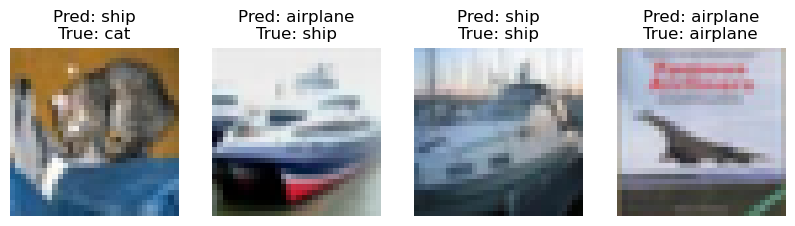

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
# 数据预处理
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载测试集
testset = torchvision.datasets.CIFAR10(
root='./data', train=False,
download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
testset, batch_size=64, shuffle=False, num_workers=2
)



# 定义 CNN 模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 创建模型实例
net = Net()

# 如果你之前训练过模型并保存了参数，加载它：
# net.load_state_dict(torch.load("your_model_path.pth"))

# 放到 GPU 或 CPU 上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# 数据预处理
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载测试集
testset = torchvision.datasets.CIFAR10(
root='./data', train=False,
download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
testset, batch_size=64, shuffle=False, num_workers=2
)

# 从测试集中取出一批数据
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images[:4], labels[:4]  # 取前4张作为示例
outputs = net(images.to(device))
_, preds = torch.max(outputs, 1)
preds = preds.cpu()  # 移回CPU便于后续处理

# 准备展示
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for idx in range(4):
    img = images[idx] / 2 + 0.5  # 将图像反归一化: 原来做了 Normalize(0.5,0.5,0.5), 这里乘0.5加0.5还原到[0,1]
    npimg = img.numpy()         # 转为numpy数组
    npimg = np.transpose(npimg, (1, 2, 0))  # 转换维度，从(channels, H, W)到(H, W, channels)
    axes[idx].imshow(npimg)
    true_label = classes[labels[idx].item()]
    pred_label = classes[preds[idx].item()]
    axes[idx].set_title(f"Pred: {pred_label}\nTrue: {true_label}")
    axes[idx].axis('off')
plt.show()


Confusion Matrix:
 [[  0  11   0   0 989   0   0   0   0   0]
 [  0   9   0   0 991   0   0   0   0   0]
 [  0   6   0   0 994   0   0   0   0   0]
 [  0  14   0   0 986   0   0   0   0   0]
 [  0   2   0   0 998   0   0   0   0   0]
 [  0   8   0   0 992   0   0   0   0   0]
 [  0  11   0   0 989   0   0   0   0   0]
 [  0   8   0   0 992   0   0   0   0   0]
 [  0   2   0   0 998   0   0   0   0   0]
 [  0   9   0   0 991   0   0   0   0   0]]


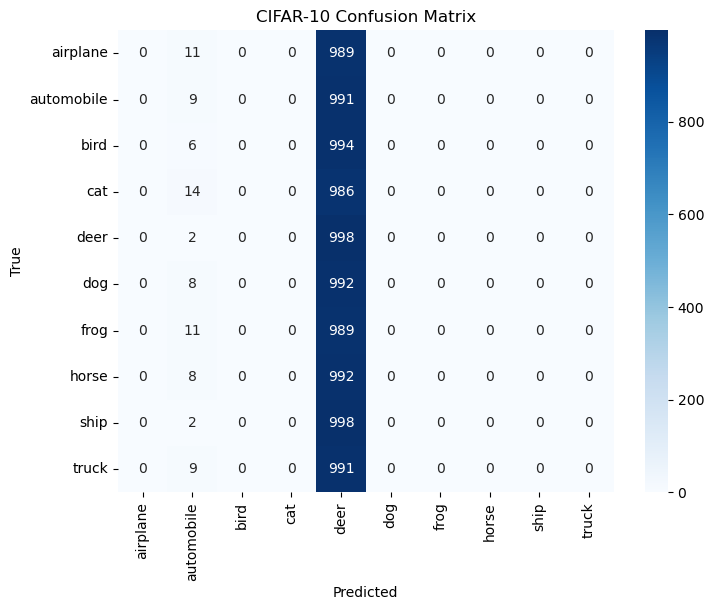

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 首先获取整个测试集上的真实标签和预测标签
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        # 收集该批次的真实标签和预测结果
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# 可视化混淆矩阵
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CIFAR-10 Confusion Matrix')
plt.show()


In [15]:
# 保存模型参数到文件
MODEL_PATH = "my_cifar10_cnn.pth"
torch.save(net.state_dict(), MODEL_PATH)
print(f"模型已保存至 {MODEL_PATH}")

# ......（在需要时，比如重启后或另一个脚本中）......

# 加载模型参数
net_loaded = Net()                        # 先创建模型对象（结构需与保存时相同）
net_loaded.load_state_dict(torch.load(MODEL_PATH))
net_loaded.to(device)
net_loaded.eval()                         # 如仅用于推理，设置为评估模式
print("模型已从文件加载并准备就绪!")


模型已保存至 my_cifar10_cnn.pth
模型已从文件加载并准备就绪!


C:\Users\HP\AppData\Local\Temp\ipykernel_29528\3112337579.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded.load_state_dict(torch.load(MODEL_PATH))
